### Importing and Loadings

In [30]:
from conf.parameters import parameters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import plotly.express as px
import seaborn as sns

In [6]:
def load_data(data_path):
    """
    Load the dataset from the specified data path in the parameters file.

    Args:
        parameters["data_path"]: The data path of the dataset.

    Returns:
        pd.DataFrame: Loaded dataset as a pandas DataFrame.
    """
    # Retrieve the data path from the parameters

    # Load the Excel file into a pandas DataFrame
    df = pd.read_excel(data_path, header=1)

    return df

df = load_data(parameters["data_path"])
df.head()


,Cab_Driver_ID,Gender,PickUp_Colombo_ID,DropOff_Colombo_ID,N_Passengers,Date,PickUp_Time,Duration_Min,Tip,Total_Amount
0,5,M,2,6.650455,1,2021-10-20,Day,25,4.56,26.31
1,20,F,11,11.474133,4,2021-09-03,Night,25,0.57,22.32
2,16,F,11,12.162533,1,2021-09-22,Day,48,3.89,45.65
3,7,M,15,12.792830,3,2021-07-19,Day,30,9.64,35.74
4,15,F,5,12.668358,1,2021-11-20,Day,37,5.12,37.31


### Data Analysis


In [10]:
def check_data_types(df: pd.DataFrame) -> pd.Series:
    """
    Check the data types of each column in the dataset.

    Args:
        df (pd.DataFrame): The input DataFrame to check data types.

    Returns:
        pd.Series: A pandas Series containing the data types of each column.
    """
    return df.dtypes

check_data_types(df)

Cab_Driver_ID           int64
Gender                 object
PickUp_Colombo_ID       int64
DropOff_Colombo_ID    float64
N_Passengers            int64
Date                   object
PickUp_Time            object
Duration_Min            int64
Tip                   float64
Total_Amount          float64
dtype: object

In [13]:
def generate_summary_stats(df: pd.DataFrame, drop_columns: list = None) -> pd.DataFrame:
    """
    Generate summary statistics for numerical columns, excluding specified columns.

    Args:
        df (pd.DataFrame): The input DataFrame containing the dataset.
        drop_columns (list, optional): A list of columns to exclude from the summary statistics. Default is None.

    Returns:
        pd.DataFrame: Summary statistics (mean, std, min, max, quartiles) for numerical columns.
    """
    # If drop_columns is specified, exclude those columns from the DataFrame
    if drop_columns is not None:
        df_features = df.drop(columns=drop_columns)
    else:
        df_features = df

    # Generate and return summary statistics for numerical columns
    summary_stats = df_features.describe()

    return summary_stats

# Specify columns to drop (e.g., ID columns)
columns_to_drop = ['Cab_Driver_ID', 'PickUp_Colombo_ID', 'DropOff_Colombo_ID']

# Generate summary statistics excluding specified columns
summary_stats = generate_summary_stats(df, drop_columns=columns_to_drop)
summary_stats

,N_Passengers,Duration_Min,Tip,Total_Amount
count,999.000000,999.000000,999.000000,999.000000
mean,2.482482,30.477477,4.985956,31.501361
std,1.129600,14.594768,2.969104,12.969897
min,1.000000,7.000000,0.000000,6.390000
25%,1.000000,17.000000,2.375000,20.305000
50%,2.000000,30.000000,5.040000,31.560000
75%,3.000000,43.000000,7.510000,42.170000
max,4.000000,55.000000,9.990000,57.350000


In [14]:
def check_missing_values(df: pd.DataFrame) -> pd.Series:
    """
    Check for missing values in the dataset and return the count of missing values per column.

    Args:
        df (pd.DataFrame): The input DataFrame to check for missing values.

    Returns:
        pd.Series: A pandas Series containing the count of missing values for each column.
    """
    # Check for missing values in the dataset
    missing_values = df.isnull().sum()

    return missing_values

missing_values = check_missing_values(df)
missing_values

Cab_Driver_ID         0
Gender                0
PickUp_Colombo_ID     0
DropOff_Colombo_ID    0
N_Passengers          0
Date                  0
PickUp_Time           0
Duration_Min          0
Tip                   0
Total_Amount          0
dtype: int64

In [6]:
def check_nan_values(df: pd.DataFrame) -> pd.Series:
    """
    Check for NaN values in all columns of the DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame to check for NaN values.

    Returns:
        pd.Series: A series with the count of NaN values in each column.
    """
    # Check for NaN values and return the count of NaNs in each column
    return df.isna().sum()

nan_values = check_nan_values(df)
nan_values

Cab_Driver_ID         0
Gender                0
PickUp_Colombo_ID     0
DropOff_Colombo_ID    0
N_Passengers          0
Date                  0
PickUp_Time           0
Duration_Min          0
Tip                   0
Total_Amount          0
dtype: int64

### Analysis on Gender and their average earnings


In [39]:
def calculate_aggregated_earnings(df: pd.DataFrame, date_column: str, earnings_column: str, driver_id_column: str, time_of_day_column: str) -> dict:
    """
    Calculate the total and average earnings for all drivers across daily, weekly, and monthly periods.

    Args:
        df (pd.DataFrame): The input DataFrame containing the dataset.
        date_column (str): The column name for the trip date.
        earnings_column (str): The column name for trip earnings.
        driver_id_column (str): The column name for cab driver ID.

    Returns:
        dict: A dictionary containing daily, weekly, and monthly averages for a driver.
    """
    if date_column not in df.columns or earnings_column not in df.columns or driver_id_column not in df.columns:
        raise ValueError("Specified columns do not exist in the DataFrame.")

    # Ensure the date column is a datetime type
    df[date_column] = pd.to_datetime(df[date_column])

    # Filter the data for 'Night' time of day
    df = df[df[time_of_day_column] == 'Night']

    # Add Week and Month columns for aggregation
    df['Week'] = df[date_column].dt.isocalendar().week
    df['Month'] = df[date_column].dt.to_period('M')

    # Calculate total earnings across all drivers for daily, weekly, and monthly periods
    total_daily_earnings = df.groupby(df[date_column].dt.date)[earnings_column].sum()
    total_weekly_earnings = df.groupby('Week')[earnings_column].sum()
    total_monthly_earnings = df.groupby('Month')[earnings_column].sum()

    # Calculate the number of unique drivers who worked for each period
    daily_drivers = df.groupby(df[date_column].dt.date)[driver_id_column].nunique()
    weekly_drivers = df.groupby('Week')[driver_id_column].nunique()
    monthly_drivers = df.groupby('Month')[driver_id_column].nunique()

    # Calculate average earnings per driver for each period
    avg_daily_earnings_per_driver = (total_daily_earnings / daily_drivers).reset_index(name='Average Earnings Per Driver')
    avg_weekly_earnings_per_driver = (total_weekly_earnings / weekly_drivers).reset_index(name='Average Earnings Per Driver')
    avg_monthly_earnings_per_driver = (total_monthly_earnings / monthly_drivers).reset_index(name='Average Earnings Per Driver')

    # Return results as a dictionary
    return {
        "daily_avg_per_driver": avg_daily_earnings_per_driver,
        "weekly_avg_per_driver": avg_weekly_earnings_per_driver,
        "monthly_avg_per_driver": avg_monthly_earnings_per_driver
    }


# Calculate aggregated earnings
averages = calculate_aggregated_earnings(
    df,
    date_column="Date",
    earnings_column="Total_Amount",
    driver_id_column="Cab_Driver_ID",
    time_of_day_column="PickUp_Time"
)

# Display results
print("Daily Average Earnings Per Driver:")
print(averages["daily_avg_per_driver"])

print("\nWeekly Average Earnings Per Driver:")
print(averages["weekly_avg_per_driver"])

print("\nMonthly Average Earnings Per Driver:")
print(averages["monthly_avg_per_driver"])


Daily Average Earnings Per Driver:
           Date  Average Earnings Per Driver
0    2021-07-01                    14.160000
1    2021-07-02                    16.660000
2    2021-07-03                    44.600000
3    2021-07-04                    30.776667
4    2021-07-05                    24.080000
..          ...                          ...
140  2021-12-26                    36.050000
141  2021-12-28                    47.180000
142  2021-12-29                    39.020000
143  2021-12-30                    26.350000
144  2021-12-31                    40.390000

[145 rows x 2 columns]

Weekly Average Earnings Per Driver:
    Week  Average Earnings Per Driver
0     26                    36.707143
1     27                    59.962500
2     28                    32.564444
3     29                    33.018000
4     30                    44.590000
5     31                    37.221429
6     32                    62.108333
7     33                    53.808333
8     34              

C:\Users\kithuniw\AppData\Local\Temp\ipykernel_20856\2392555634.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Week'] = df[date_column].dt.isocalendar().week
C:\Users\kithuniw\AppData\Local\Temp\ipykernel_20856\2392555634.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df[date_column].dt.to_period('M')


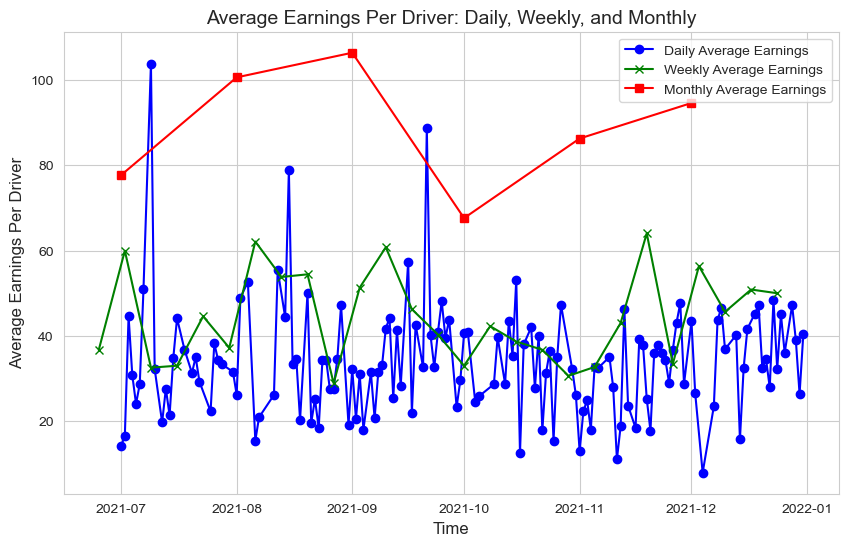

In [40]:
def plot_average_earnings_matplotlib(averages: dict):
    """
    Plot a line chart for daily, weekly, and monthly average earnings per driver using Matplotlib.

    Args:
        averages (dict): A dictionary containing daily, weekly, and monthly average earnings per driver.
    """
    # Prepare data for plotting
    daily_data = averages["daily_avg_per_driver"]
    weekly_data = averages["weekly_avg_per_driver"]
    monthly_data = averages["monthly_avg_per_driver"]

    # Convert weekly data 'Week' to the starting date of each week in 2022
    # Start of the year is assumed to be 2022-01-01 and adding the necessary days to find the start of each week.
    weekly_data['Week_Start'] = pd.to_datetime('2021-01-01') + pd.to_timedelta((weekly_data['Week'] - 1) * 7, unit='D')

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot daily average earnings
    plt.plot(daily_data['Date'], daily_data['Average Earnings Per Driver'], label='Daily Average Earnings', color='blue', marker='o')

    # Plot weekly average earnings (week start date)
    plt.plot(weekly_data['Week_Start'], weekly_data['Average Earnings Per Driver'], label='Weekly Average Earnings', color='green', marker='x')

    # Plot monthly average earnings (assuming Month is in 'YYYY-MM' format)
   ## monthly_data['Month'] = pd.to_datetime(monthly_data['Month'], format='%Y-%m').dt.to_period('M') # Convert month to datetime
    monthly_data['Month'] = monthly_data['Month'].dt.to_timestamp()
    plt.plot(monthly_data['Month'], monthly_data['Average Earnings Per Driver'], label='Monthly Average Earnings', color='red', marker='s')

    # Add title and labels
    plt.title("Average Earnings Per Driver: Daily, Weekly, and Monthly", fontsize=14)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Average Earnings Per Driver", fontsize=12)

    # Add legend
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()

# Call the plotting function
plot_average_earnings_matplotlib(averages)


In [3]:
def calculate_driver_stats(df, ID_column, gender_column, earnings_column):
    """
    Calculate stats for drivers including total, gender distribution, and averages,
    considering only unique driver IDs for gender distribution.

    Args:
        df (pd.DataFrame): The dataset containing driver data.
        gender_column (str): The column name for driver gender.
        earnings_column (str): The column name for driver earnings.
        tipping_column (str): The column name for driver tipping.

    Returns:
        dict: Dictionary containing stats for drivers.
    """
    # Ensure the gender column is a string and remove any leading/trailing spaces
    df[gender_column] = df[gender_column].astype(str).str.strip()  # Convert to string and remove spaces

    # Total number of unique drivers
    total_drivers = df[ID_column].nunique()

    # Gender distribution (count unique IDs per gender)
    gender_counts = df.drop_duplicates(subset=[ID_column])[gender_column].value_counts().to_dict()

    # Average earnings for each gender
    average_earnings_by_gender = df.groupby(gender_column)[earnings_column].mean().to_dict()

    # Results
    stats = {
        "Total Drivers": total_drivers,
        "Gender Distribution": gender_counts,
        "Average Earnings by Gender": average_earnings_by_gender
    }

    return stats


driver_stats = calculate_driver_stats(df, ID_column='Cab_Driver_ID', gender_column='Gender', earnings_column='Total_Amount')
print(driver_stats)


{'Total Drivers': 20, 'Gender Distribution': {'M': 13, 'F': 7}, 'Average Earnings by Gender': {'F': 31.492282608695653, 'M': 31.50665610142631}}


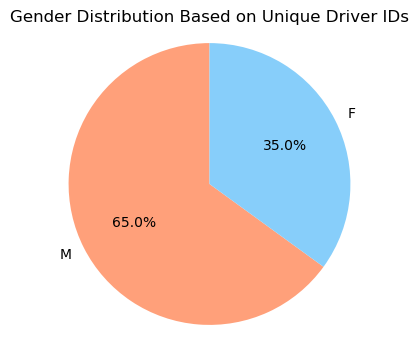

In [5]:
def plot_gender_distribution(df: pd.DataFrame, ID_column: str, gender_column: str):
    """
    Plot a pie chart showing the distribution of genders based on unique driver IDs.

    Args:
        df (pd.DataFrame): The input DataFrame containing the dataset.
        ID_column (str): The column name representing the driver ID.
        gender_column (str): The column name representing the gender.
    """
    if gender_column not in df.columns:
        raise ValueError("Specified gender column does not exist in the DataFrame.")
    if ID_column not in df.columns:
        raise ValueError("Specified ID column does not exist in the DataFrame.")

    # Drop duplicates to get unique driver IDs
    unique_drivers = df.drop_duplicates(subset=[ID_column])

    # Calculate gender counts based on unique driver IDs
    gender_counts = unique_drivers[gender_column].value_counts()

    # Plot pie chart
    plt.figure(figsize=(4, 4))
    plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=["#FFA07A", "#87CEFA"])
    plt.title("Gender Distribution Based on Unique Driver IDs")
    plt.axis('equal')  # Ensures the pie chart is a perfect circle
    plt.show()


plot_gender_distribution(df, ID_column="Cab_Driver_ID", gender_column="Gender")


In [35]:
def calculate_weekly_earnings_by_gender(df, date_column, earnings_column, gender_column, id_column, time_of_day_column):
    """
    Calculate weekly average earnings by gender for unique drivers who worked during the night.

    Parameters:
    - df: DataFrame containing the data.
    - date_column: The column containing the dates of the records.
    - earnings_column: The column containing the earnings data.
    - gender_column: The column containing gender information.
    - id_column: The column identifying unique drivers.
    - time_of_day_column: The column indicating whether the time is day or night.

    Returns:
    - DataFrame with weekly average earnings by gender.
    """

    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])

    # Filter the data for 'Night' time of day
    df_night = df[df[time_of_day_column] == 'Night']

    # Add a column for the week (start of the week)
    df_night['Week'] = df_night[date_column].dt.to_period('W').dt.start_time

    # Drop duplicates to ensure unique drivers per week
    unique_drivers_weekly = df_night.drop_duplicates(subset=[id_column, 'Week'])

    # Group by gender and week, calculate total earnings and count unique drivers
    weekly_stats = (
        unique_drivers_weekly.groupby([gender_column, 'Week'])
                             .agg(Total_Earnings=(earnings_column, 'sum'),
                                  Unique_Drivers=(id_column, 'nunique'))
                             .reset_index()
    )

    # Calculate the average earnings per unique driver
    weekly_stats['Weekly_Average_Earnings'] = (
        weekly_stats['Total_Earnings'] / weekly_stats['Unique_Drivers']
    )

    # Drop intermediate columns if needed
    weekly_stats = weekly_stats[[gender_column, 'Week', 'Weekly_Average_Earnings']]

    return weekly_stats

# Example Usage
weekly_earnings = calculate_weekly_earnings_by_gender(
    df,
    date_column='Date',
    earnings_column='Total_Amount',
    gender_column='Gender',
    id_column='Cab_Driver_ID',
    time_of_day_column='PickUp_Time'
)

# Display the result
print(weekly_earnings)


   Gender       Week  Weekly_Average_Earnings
0       F 2021-06-28                42.590000
1       F 2021-07-12                31.370000
2       F 2021-07-19                24.950000
3       F 2021-07-26                21.550000
4       F 2021-08-02                33.090000
5       F 2021-08-09                51.340000
6       F 2021-08-16                22.410000
7       F 2021-08-23                17.480000
8       F 2021-08-30                25.030000
9       F 2021-09-06                34.180000
10      F 2021-09-13                43.292000
11      F 2021-09-20                37.977500
12      F 2021-09-27                30.840000
13      F 2021-10-04                27.366667
14      F 2021-10-11                34.586667
15      F 2021-10-18                33.482500
16      F 2021-10-25                26.810000
17      F 2021-11-01                15.513333
18      F 2021-11-08                29.370000
19      F 2021-11-15                33.730000
20      F 2021-11-22              

C:\Users\kithuniw\AppData\Local\Temp\ipykernel_20856\2324802798.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_night['Week'] = df_night[date_column].dt.to_period('W').dt.start_time


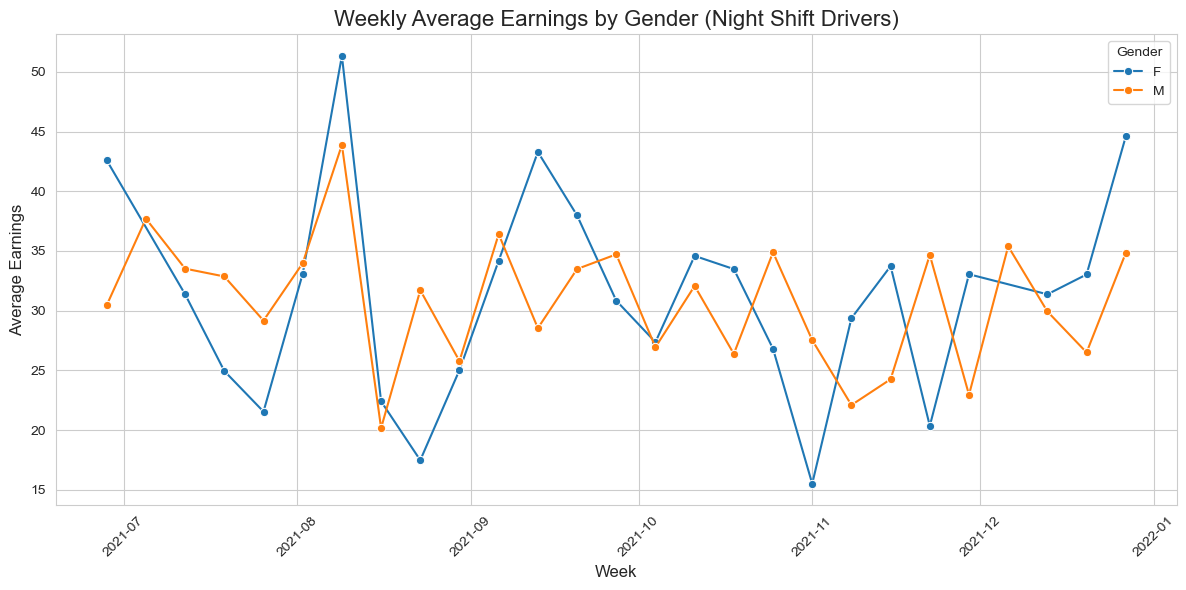

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_weekly_earnings(weekly_earnings):
    """
    Plot weekly average earnings by gender.

    Parameters:
    - weekly_earnings: DataFrame with columns 'Gender', 'Week', and 'Weekly_Average_Earnings'.
    """
    # Convert 'Week' to a datetime object for plotting
    weekly_earnings['Week'] = pd.to_datetime(weekly_earnings['Week'])

    # Set the plot style
    sns.set_style("whitegrid")

    # Create the line plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=weekly_earnings,
        x='Week',
        y='Weekly_Average_Earnings',
        hue='Gender',
        marker='o'
    )

    # Add labels and title
    plt.title("Weekly Average Earnings by Gender (Night Shift Drivers)", fontsize=16)
    plt.xlabel("Week", fontsize=12)
    plt.ylabel("Average Earnings", fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend(title="Gender")
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example Usage
plot_weekly_earnings(weekly_earnings)


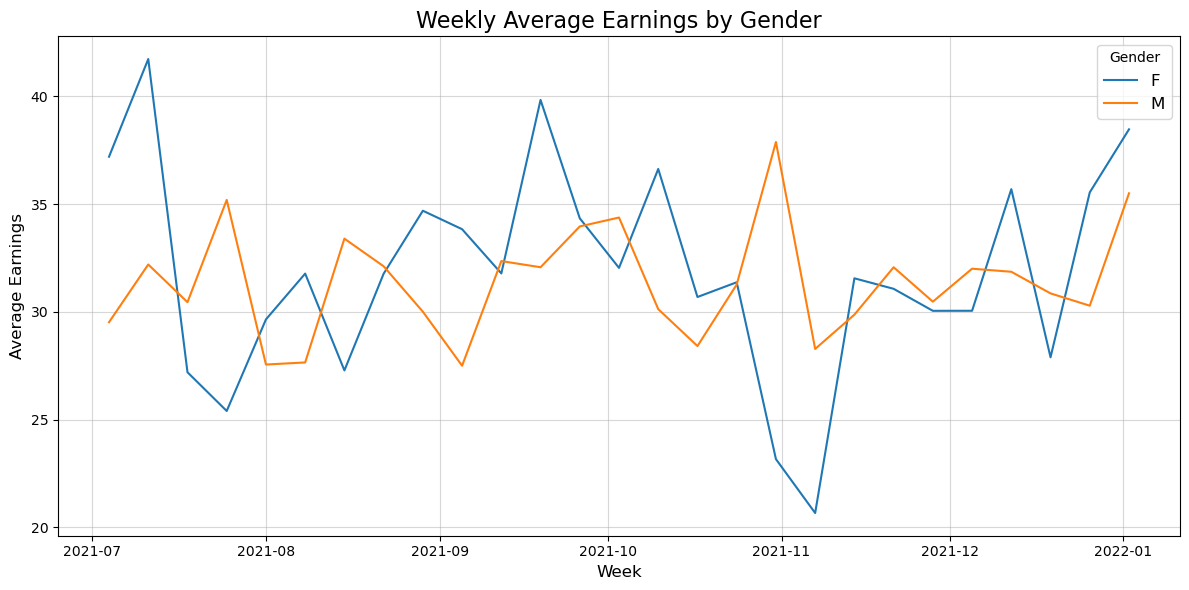

In [22]:
def plot_weekly_earnings_by_gender(weekly_earnings: pd.DataFrame, date_column: str, earnings_column: str, gender_column: str):
    """
    Plot weekly average earnings for each gender using a line chart.

    Args:
        weekly_earnings (pd.DataFrame): The DataFrame containing weekly average earnings by gender.
        date_column (str): The name of the column representing the date.
        earnings_column (str): The name of the column representing the earnings.
        gender_column (str): The name of the column representing the gender.
    """
    plt.figure(figsize=(12, 6))

    # Plot each gender's data
    for gender in weekly_earnings[gender_column].unique():
        gender_data = weekly_earnings[weekly_earnings[gender_column] == gender]
        plt.plot(gender_data[date_column], gender_data[earnings_column], label=gender)

    # Add chart details
    plt.title("Weekly Average Earnings by Gender", fontsize=16)
    plt.xlabel("Week", fontsize=12)
    plt.ylabel("Average Earnings", fontsize=12)
    plt.legend(title="Gender", fontsize=12)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_weekly_earnings_by_gender(weekly_earnings, date_column="Date", earnings_column="Total_Amount", gender_column="Gender")

### Analysis on Total earnings during weekdays and weekends

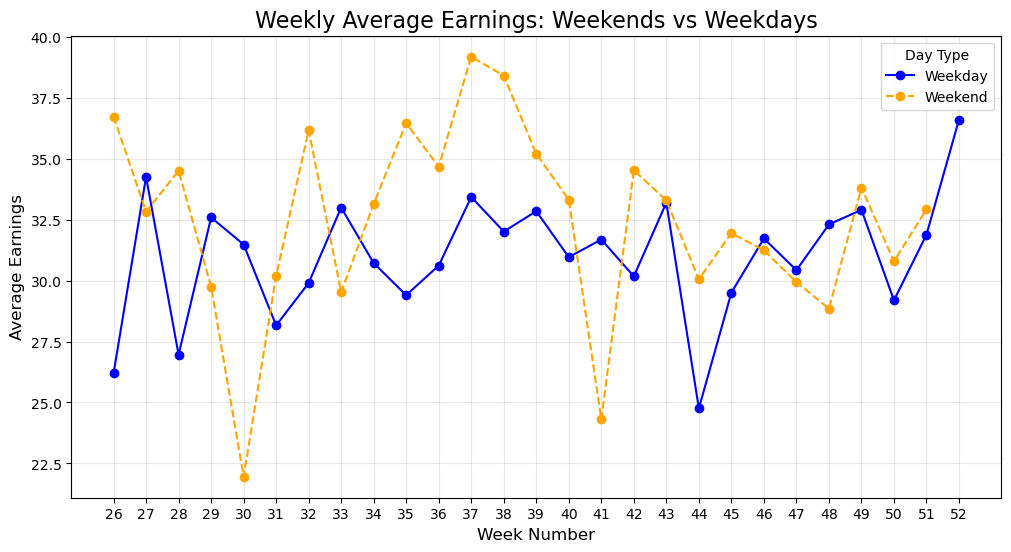

In [30]:
def plot_weekly_earnings_line_chart(df, date_column, earnings_column):
    """
    Plot a line chart for weekly average earnings comparing weekends and weekdays.

    Args:
        df (pd.DataFrame): The dataset containing trip data.
        date_column (str): The column name for the trip date.
        earnings_column (str): The column name for trip earnings.
    """
    # Ensure the date column is a datetime type
    df[date_column] = pd.to_datetime(df[date_column])

    # Add a column for the week number
    df['WeekNumber'] = df[date_column].dt.isocalendar().week

    # Add a column for day of the week
    df['DayOfWeek'] = df[date_column].dt.dayofweek

    # Classify days as "Weekday" or "Weekend"
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

    # Group by week number and weekend/weekday classification
    weekly_earnings = df.groupby(['WeekNumber', 'IsWeekend'])[earnings_column].mean().reset_index()

    # Pivot for line chart
    earnings_pivot = weekly_earnings.pivot(index='WeekNumber', columns='IsWeekend', values=earnings_column)

    # Plot line chart
    plt.figure(figsize=(12, 6))
    plt.plot(earnings_pivot.index, earnings_pivot['Weekday'], label='Weekday', marker='o', linestyle='-', color='blue')
    plt.plot(earnings_pivot.index, earnings_pivot['Weekend'], label='Weekend', marker='o', linestyle='--', color='orange')

    # Chart customization
    plt.title('Weekly Average Earnings: Weekends vs Weekdays', fontsize=16)
    plt.xlabel('Week Number', fontsize=12)
    plt.ylabel('Average Earnings', fontsize=12)
    plt.xticks(ticks=earnings_pivot.index, labels=earnings_pivot.index, fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title='Day Type', fontsize=10)
    plt.grid(alpha=0.3)

    # Show the plot
    plt.show()


plot_weekly_earnings_line_chart(df, date_column='Date', earnings_column='Total_Amount')

Analysis on

In [45]:
 def analyze_profitability(df):
    """
    Analyze profitability metrics (total and average earnings, tips, passengers, duration)
    grouped by Colombo state, time of day, and gender.

    Args:
        df (pd.DataFrame): The dataset containing cab trip data.

    Returns:
        pd.DataFrame: Aggregated metrics by Colombo state, time of day, and gender.
    """


    # Group and aggregate metrics
    state_metrics = df.groupby(['PickUp_Colombo_ID', 'PickUp_Time', 'Gender']).agg({
        'Total_Amount': ['sum', 'mean'],  # Total and average earnings
        'Tip': 'mean',                    # Average tips
        'N_Passengers': 'mean',           # Average passengers per trip
        'Duration_Min': 'mean'            # Average trip duration
    }).reset_index()

    # Flatten multi-level column names
    state_metrics.columns = [
        'Colombo_State', 'PickUp_Time', 'Gender',
        'Total_Earnings', 'Avg_Earnings', 'Avg_Tip',
        'Avg_Passengers', 'Avg_Duration'
    ]

    return state_metrics

 # Call the analyze_profitability function
state_metrics = analyze_profitability(df)

# Print the resulting DataFrame
print(state_metrics)


    Colombo_State PickUp_Time Gender  Total_Earnings  Avg_Earnings   Avg_Tip  \
0               1         Day      F          782.72     30.104615  3.770385   
1               1         Day      M          667.39     29.016957  5.224348   
2               1       Night      F          172.46     28.743333  6.123333   
3               1       Night      M          487.13     32.475333  6.027333   
4               2         Day      F          351.59     23.439333  4.937333   
5               2         Day      M         1059.48     34.176774  5.635161   
6               2       Night      F          247.05     30.881250  5.433750   
7               2       Night      M          423.47     32.574615  5.805385   
8               3         Day      F          456.16     28.510000  5.455000   
9               3         Day      M         1099.09     35.454516  5.397419   
10              3       Night      F          331.84     30.167273  4.700000   
11              3       Night      M    

### Analysis of places to be to get profitable fares

In [7]:
def group_data_by_state_gender_time(df: pd.DataFrame) -> pd.DataFrame:
    """
    Group data by state, gender, and time of day and calculate total and average earnings.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A DataFrame containing grouped data with calculated metrics.
    """
    grouped_data = df.groupby(['PickUp_Colombo_ID', 'Gender', 'PickUp_Time']).agg({
        'Total_Amount': ['sum', 'mean', 'count']
    }).reset_index()

    grouped_data.columns = ['PickUp_Colombo_ID', 'Gender', 'PickUp_Time',
                            'Total_Earnings', 'Average_Earnings', 'Ride_Count']
    return grouped_data

grouped_data = group_data_by_state_gender_time(df)
grouped_data.head()

,PickUp_Colombo_ID,Gender,PickUp_Time,Total_Earnings,Average_Earnings,Ride_Count
0,1,F,Day,782.72,30.104615,26
1,1,F,Night,172.46,28.743333,6
2,1,M,Day,667.39,29.016957,23
3,1,M,Night,487.13,32.475333,15
4,2,F,Day,351.59,23.439333,15


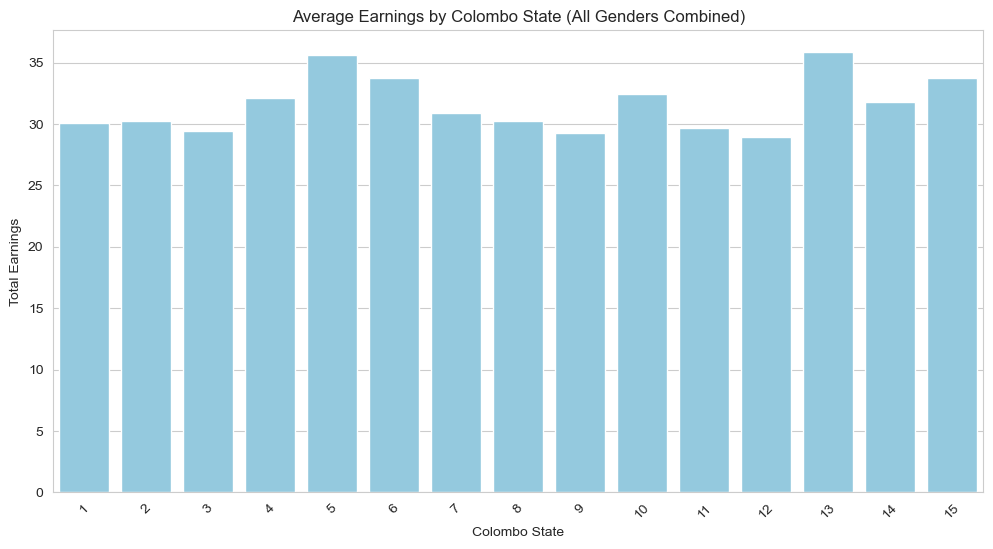

In [62]:
def visualize_average_earnings_by_state(grouped_data: pd.DataFrame):
    """
    Visualize total earnings by state, combining earnings for all genders.

    Args:
        grouped_data (pd.DataFrame): The grouped DataFrame with earnings metrics.
    """
    # Aggregate total earnings by state
    total_earnings_by_state = grouped_data.groupby('PickUp_Colombo_ID')['Average_Earnings'].mean().reset_index()

    # Plot the total earnings by state
    plt.figure(figsize=(12, 6))
    sns.barplot(data=total_earnings_by_state, x='PickUp_Colombo_ID', y='Average_Earnings', color="skyblue")
    plt.title('Average Earnings by Colombo State (All Genders Combined)')
    plt.xlabel('Colombo State')
    plt.ylabel('Total Earnings')
    plt.xticks(rotation=45)
    plt.show()

# Example usage
visualize_average_earnings_by_state(grouped_data)


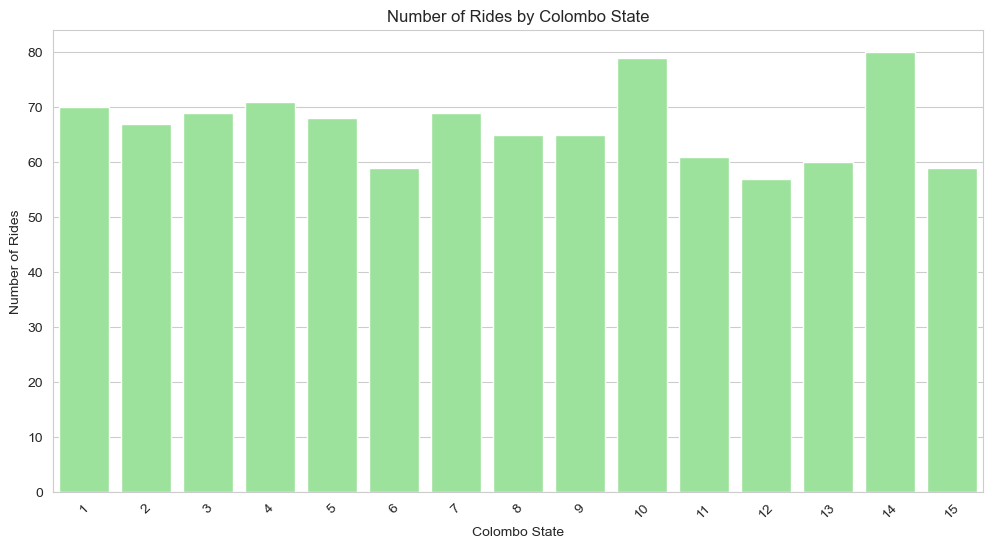

In [55]:
def visualize_rides_by_state(grouped_data: pd.DataFrame):
    """
    Visualize the number of rides by state.

    Args:
        grouped_data (pd.DataFrame): The grouped DataFrame with ride metrics.
    """
    # Count the number of rides per state
    rides_by_state = grouped_data.groupby('PickUp_Colombo_ID').size().reset_index(name='Number_of_Rides')

    # Plot the number of rides by state
    plt.figure(figsize=(12, 6))
    sns.barplot(data=rides_by_state, x='PickUp_Colombo_ID', y='Number_of_Rides', color="lightgreen")
    plt.title('Number of Rides by Colombo State')
    plt.xlabel('Colombo State')
    plt.ylabel('Number of Rides')
    plt.xticks(rotation=45)
    plt.show()

# Example usage
visualize_rides_by_state(df)


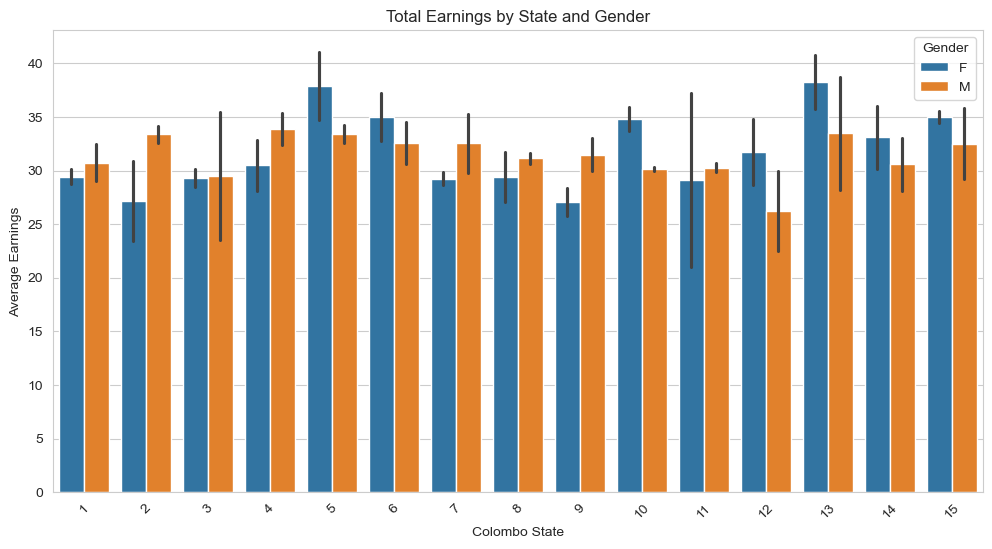

In [48]:
def visualize_total_earnings_by_state_and_gender(grouped_data: pd.DataFrame):
    """
    Visualize total earnings by state and gender.

    Args:
        grouped_data (pd.DataFrame): The grouped DataFrame with earnings metrics.
    """
    plt.figure(figsize=(12, 6))
    sns.barplot(data=grouped_data, x='PickUp_Colombo_ID', y='Average_Earnings', hue='Gender')
    plt.title('Total Earnings by State and Gender')
    plt.xlabel('Colombo State')
    plt.ylabel('Average Earnings')
    plt.xticks(rotation=45)
    plt.show()

# Visualize insights
visualize_total_earnings_by_state_and_gender(grouped_data)

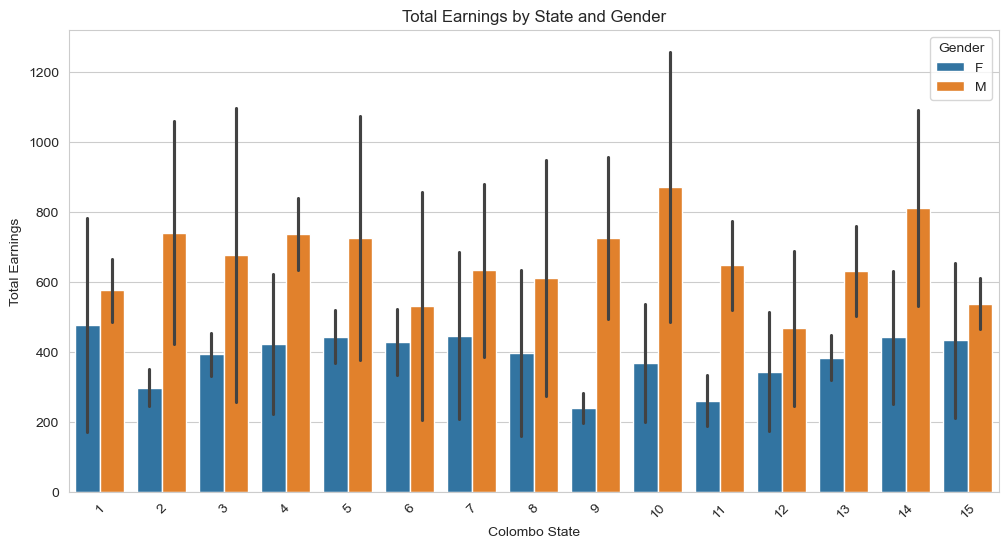

In [51]:
def visualize_total_earnings_by_state_and_gender(grouped_data: pd.DataFrame):
    """
    Visualize total earnings by state and gender.

    Args:
        grouped_data (pd.DataFrame): The grouped DataFrame with earnings metrics.
    """
    plt.figure(figsize=(12, 6))
    sns.barplot(data=grouped_data, x='PickUp_Colombo_ID', y='Total_Earnings', hue='Gender')
    plt.title('Total Earnings by State and Gender')
    plt.xlabel('Colombo State')
    plt.ylabel('Total Earnings')
    plt.xticks(rotation=45)
    plt.show()

visualize_total_earnings_by_state_and_gender(grouped_data)

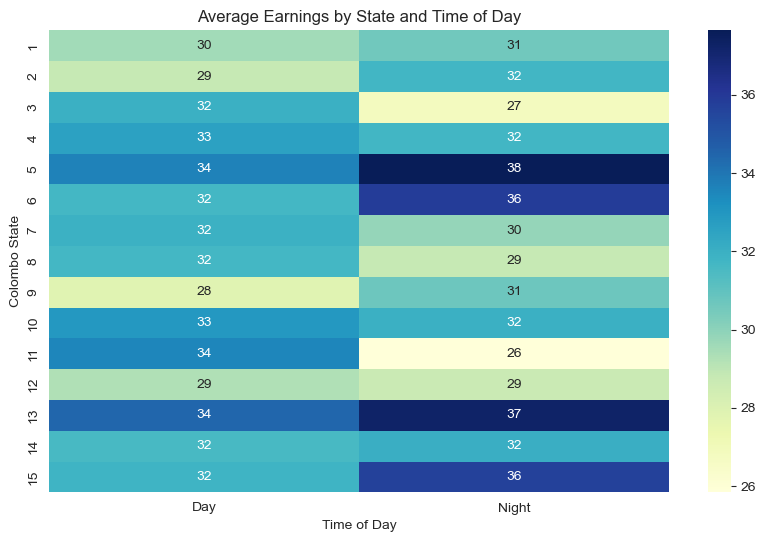

In [53]:
def visualize_earnings_by_time_of_day(grouped_data: pd.DataFrame):
    """
    Visualize average earnings by time of day using a heatmap.

    Args:
        grouped_data (pd.DataFrame): The grouped DataFrame with earnings metrics.
    """
    earnings_pivot = grouped_data.pivot_table(index='PickUp_Colombo_ID',
                                               columns='PickUp_Time',
                                               values='Average_Earnings',
                                               aggfunc='mean')

    plt.figure(figsize=(10, 6))
    sns.heatmap(earnings_pivot, annot=True, cmap='YlGnBu')
    plt.title('Average Earnings by State and Time of Day')
    plt.xlabel('Time of Day')
    plt.ylabel('Colombo State')
    plt.show()

visualize_earnings_by_time_of_day(grouped_data)

### Analysis on Tips


In [17]:
def calculate_tipping_rate(df):
    """
    Add a Tipping_Rate column to the DataFrame.

    Parameters:
    df (pd.DataFrame): Input DataFrame with 'Tip_Amount' and 'Total_Amount' columns.

    Returns:
    pd.DataFrame: Updated DataFrame with 'Tipping_Rate' column.
    """
    df['Tip_rate'] = df['Tip'] / df['Total_Amount']
    return df

df = calculate_tipping_rate(df)


In [20]:
def aggregate_tipping_rates(df):
    """
    Group by State_ID and calculate the mean tipping rate.

    Parameters:
    df (pd.DataFrame): Input DataFrame with 'State_ID' and 'Tipping_Rate' columns.

    Returns:
    pd.DataFrame: Aggregated DataFrame with mean tipping rates.
    """
    return df.groupby('PickUp_Colombo_ID').agg({'Tip_rate': 'mean'}).reset_index()

aggregated_data = aggregate_tipping_rates(df)
aggregated_data

,PickUp_Colombo_ID,Tip_rate
0,1,0.184489
1,2,0.212771
2,3,0.181358
3,4,0.175485
4,5,0.167917
5,6,0.196589
6,7,0.185315
7,8,0.194574
8,9,0.192073
9,10,0.185359


Original DataFrame:
   PickUp_Colombo_ID  Tip_rate
0                  1  0.184489
1                  2  0.212771
2                  3  0.181358
3                  4  0.175485
4                  5  0.167917
Heatmap data after pivot:
                   Tip_rate
PickUp_Colombo_ID          
1                  0.184489
2                  0.212771
3                  0.181358
4                  0.175485
5                  0.167917


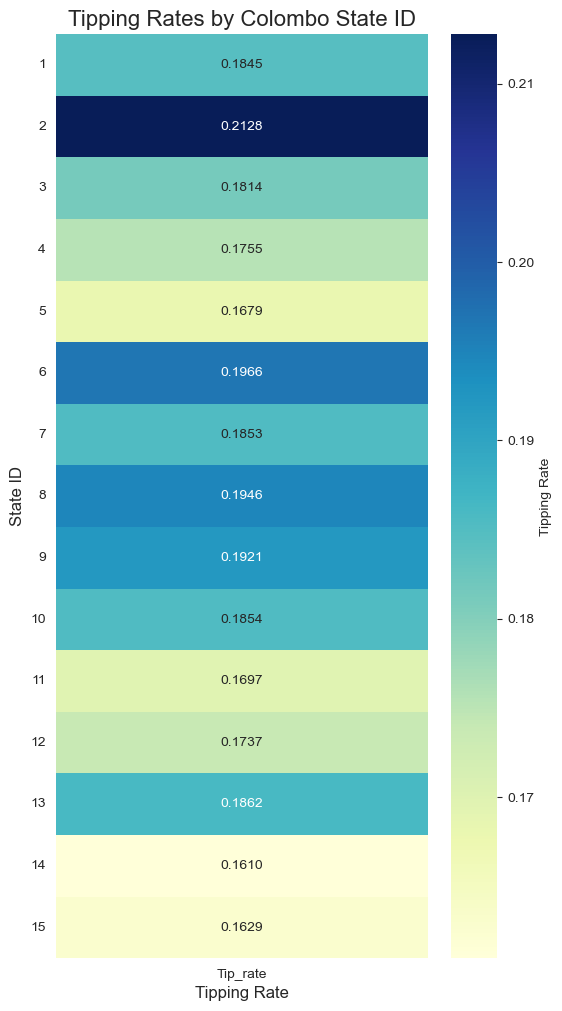

In [31]:
def plot_debugged_heatmap(data, title='Tipping Rates by Colombo State ID'):
    """
    Plot a heatmap with a single column for tipping rates, formatted to 4 decimal points.

    Parameters:
    data (pd.DataFrame): DataFrame containing 'State_ID' and 'Tipping_Rate'.
    title (str): Title for the heatmap.

    Returns:
    None: Displays the heatmap.
    """
    try:
        print("Original DataFrame:")
        print(data.head())

        # Check for required columns
        if 'PickUp_Colombo_ID' not in data.columns or 'Tip_rate' not in data.columns:
            print("DataFrame columns are:", data.columns)
            raise ValueError("Required columns 'State_ID' and 'Tipping_Rate' are missing.")

        # Check for empty data
        if data.empty:
            raise ValueError("The input DataFrame is empty.")

        # Ensure data is sorted
        data = data.sort_values(by='PickUp_Colombo_ID')

        # Create the heatmap data
        heatmap_data = data.set_index('PickUp_Colombo_ID')[['Tip_rate']]
        print("Heatmap data after pivot:")
        print(heatmap_data.head())

        # Plot the heatmap
        plt.figure(figsize=(6, 12))
        sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".4f", cbar_kws={'label': 'Tipping Rate'})
        plt.title(title, fontsize=16)
        plt.xlabel('Tipping Rate', fontsize=12)
        plt.ylabel('State ID', fontsize=12)
        plt.yticks(rotation=0)
        plt.show()

    except Exception as e:
        print(f"Error creating heatmap: {repr(e)}")


plot_debugged_heatmap(aggregated_data)